In [1]:
data_dir = 'L:/DATA/ISIS/keras_ocr/'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

## Train the recognizer
After some research, training the detector seems hard and time consuming, so we'll start by training the recognizer with our own pictures. To train the recognizer, we need small images of digits from ionograms. I cropped 60 ionograms and their metadata. Each of them looks like this.

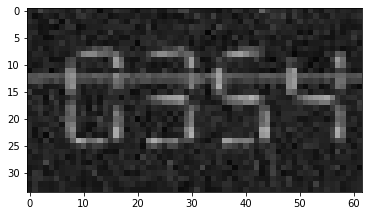

In [2]:
im = plt.imread(data_dir+'test_images/cropped/1-5.jpg')
plt.imshow(im)

I also created a txt file with the name of the images and the right numbers. I looks like this.

In [3]:
import pandas as pd

dataset = pd.read_csv(data_dir+'test_images/cropped/annotations.txt', header=None, 
                      names=['file','text'], dtype={'file' : str, 'text' : str})
dataset['file'] = data_dir+'test_images/cropped/' + dataset['file']
dataset['text'] = dataset['text'].astype(str)
dataset.insert(1, 'empty', None)

dataset.head(6)

,file,empty,text
0,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-1...,None,36
1,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-2...,None,00
2,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-3...,None,69
3,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-4...,None,11
4,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-5...,None,0354
5,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-5...,None,35


In [4]:
train_subset, test_subset = sklearn.model_selection.train_test_split(dataset, test_size=0.2)

train_subset.reset_index(inplace=True, drop=True)
test_subset.reset_index(inplace=True, drop=True)

train = []
for i in range(len(train_subset)):
    train.append(tuple(train_subset.loc[i].to_list()))

test = []
for i in range(len(test_subset)):
    test.append(tuple(test_subset.loc[i].to_list()))

In [6]:
import string
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan_notop.h5


In [7]:
batch_size = 1
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train, augmenter), (test, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

288 / 288 instances have illegal characters.
text: 50


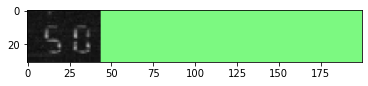

In [8]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
    workers=0,
    batch_size=batch_size
)

Epoch 1/1000
288/288 [==============================] - 45s 111ms/step - loss: 6.0628 - val_loss: 1.8387
Epoch 2/1000
288/288 [==============================] - 25s 88ms/step - loss: 1.0615 - val_loss: 2.7547
Epoch 3/1000
288/288 [==============================] - 26s 91ms/step - loss: 0.6051 - val_loss: 0.3548
Epoch 4/1000
288/288 [==============================] - 26s 90ms/step - loss: 0.4273 - val_loss: 0.1959
Epoch 5/1000
288/288 [==============================] - 26s 92ms/step - loss: 0.3152 - val_loss: 0.2457
Epoch 6/1000
288/288 [==============================] - 26s 89ms/step - loss: 0.4081 - val_loss: 0.4121
Epoch 7/1000
288/288 [==============================] - 24s 83ms/step - loss: 0.3218 - val_loss: 0.2561
Epoch 8/1000
288/288 [==============================] - 25s 87ms/step - loss: 0.1338 - val_loss: 0.3083
Epoch 9/1000
288/288 [==============================] - 25s 86ms/step - loss: 0.3186 - val_loss: 0.4187
Epoch 10/1000
288/288 [==============================] - 29s 99

1/1 [==============================] - 2s 2s/step
Predicted: 19, Actual:  19


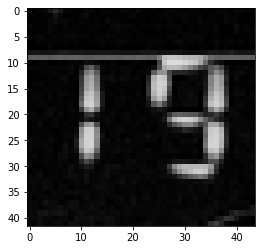

In [10]:
image_filepath, _, actual = test[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

Looking for C:\Users\mfortier\.keras-ocr\craft_mlt_25k.h5
1/1 [==============================] - 0s 324ms/step


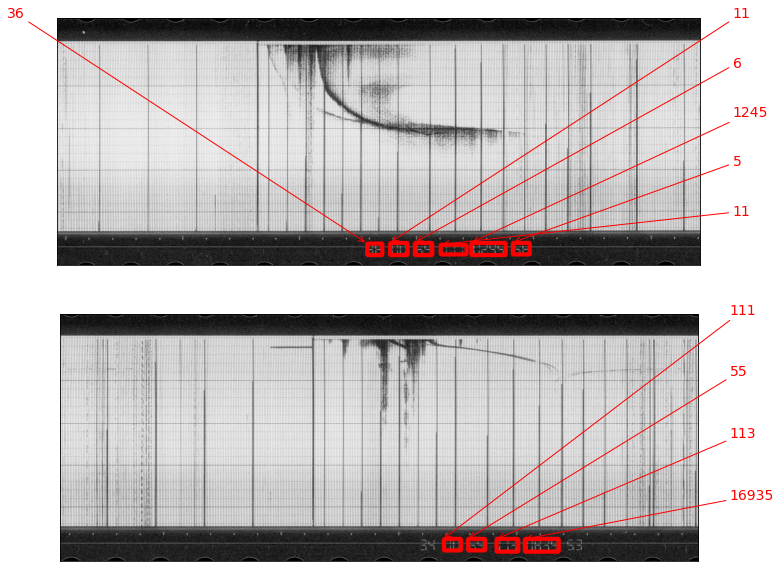

In [11]:
subdir_path = 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/'
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)
images = [keras_ocr.tools.read(img) for img in [subdir_path + 'Image0005.png',subdir_path + 'Image0338.png']]
prediction_groups = pipeline.recognize(images)
# plot the text predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(15, 10))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)

In [12]:
recognizer.model.save_weights(data_dir +'ISIS_reading.h5')